## Atividade 1 - Desenvolvimento de um Classificador Binário por Limiar
#
### Caio Eduardo Theodoro - RA: 2044560



| Biblioteca | Função |
| ------ | ----------- |
| numpy   | será utilizada para realizar operações matemáticas |
| pandas  | será utilizada para ler os arquivos csv |
| matplotlib.pyplot e seaborn | será utilizada para plotar os gráficos |
| sklearn | será utilizada para realizar a separação dos dados em treino e teste, e para realizar a classificação dos dados |

In [103]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import accuracy_score
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier

%matplotlib inline

### Renomeando as colunas do dataset
#### Faremos a leitura do dataset e renomearemos as colunas para facilitar o entendimento 

In [104]:
colunas = ['PH', 'Dureza', 'Solidos', 'Cloraminas', 'Sulfato', 'Condutividade', 'Carbono_Organico', 'Trihalometanos', 'Turbidez', 'Potabilidade']
plt.tight_layout()
df = pd.read_csv('water_potability_nonans.csv')
df = df.rename(columns={
    'ph': colunas[0],
    'Hardness': colunas[1],
    'Solids': colunas[2],
    'Chloramines': colunas[3],
    'Sulfate': colunas[4],
    'Conductivity': colunas[5],
    'Organic_carbon': colunas[6],
    'Trihalomethanes': colunas[7],
    'Turbidity': colunas[8],
    'Potability': colunas[9]
})



<Figure size 640x480 with 0 Axes>

In [105]:
df.head(4)

,PH,Dureza,Solidos,Cloraminas,Sulfato,Condutividade,Carbono_Organico,Trihalometanos,Turbidez,Potabilidade
0,8.316766,214.373394,22018.417441,8.059332,356.886136,363.266516,18.436524,100.341674,4.628771,0
1,9.092223,181.101509,17978.986339,6.546600,310.135738,398.410813,11.558279,31.997993,4.075075,0
2,5.584087,188.313324,28748.687739,7.544869,326.678363,280.467916,8.399735,54.917862,2.559708,0
3,10.223862,248.071735,28749.716544,7.513408,393.663396,283.651634,13.789695,84.603556,2.672989,0


# Explorando o dataset
### Estatisticas descritivas dos dados agrupados pela classe ((potabilidade))

##### Abaixo, podemos ver as estatísticas de cada classe, sendo eles:
-  count: quantidade de amostras
-  mean: média
-  std: desvio padrão
-  min: valor mínimo
-  25%: primeiro quartil
-  50%: mediana
-  75%: terceiro quartil
-  max: valor máximo



#### Percebemos que a relação entre as classes é relativamente equilibrada, sendo 40% de água potável e 60% de água não potável. 
#### No geral, os valores de média, desvio padrão e quartis são bem próximos entre as classes, o que pode dificultar nosso trabalho na classificação dos dados.


In [106]:

dataAgrupada = df.groupby('Potabilidade')

for coluna in df.columns:
    print(coluna)
    print(dataAgrupada[coluna].describe().T)
    print('\n')

PH
Potabilidade            0           1
count         1200.000000  811.000000
mean             7.067201    7.113791
std              1.659106    1.437623
min              1.431782    0.227499
25%              5.982888    6.256039
50%              6.992004    7.046549
75%              8.141979    7.955161
max             14.000000   11.898078


Dureza
Potabilidade            0           1
count         1200.000000  811.000000
mean           196.008440  195.908341
std             30.717642   35.301146
min             98.452931   73.492234
25%            177.313440  174.380497
50%            196.799368  197.617494
75%            214.532109  218.414531
max            300.292476  317.338124


Solidos
Potabilidade             0             1
count          1200.000000    811.000000
mean          21628.535122  22344.922883
std            8461.108693   8891.547966
min             320.942611   1198.943699
25%           15378.907323  15816.076607
50%           20507.399647  21217.158596
75%    

### Histograma dos dados agrupados pela classe ((potabilidade))

#### Considerações:
- vemos que todos os atributos possuem uma distribuição normal (o que significa que a mediana/moda é um bom indicador para representar os dados)


#### No geral, assim como a descrição estatística, os histogramas não apresentam grandes diferenças entre as classes.




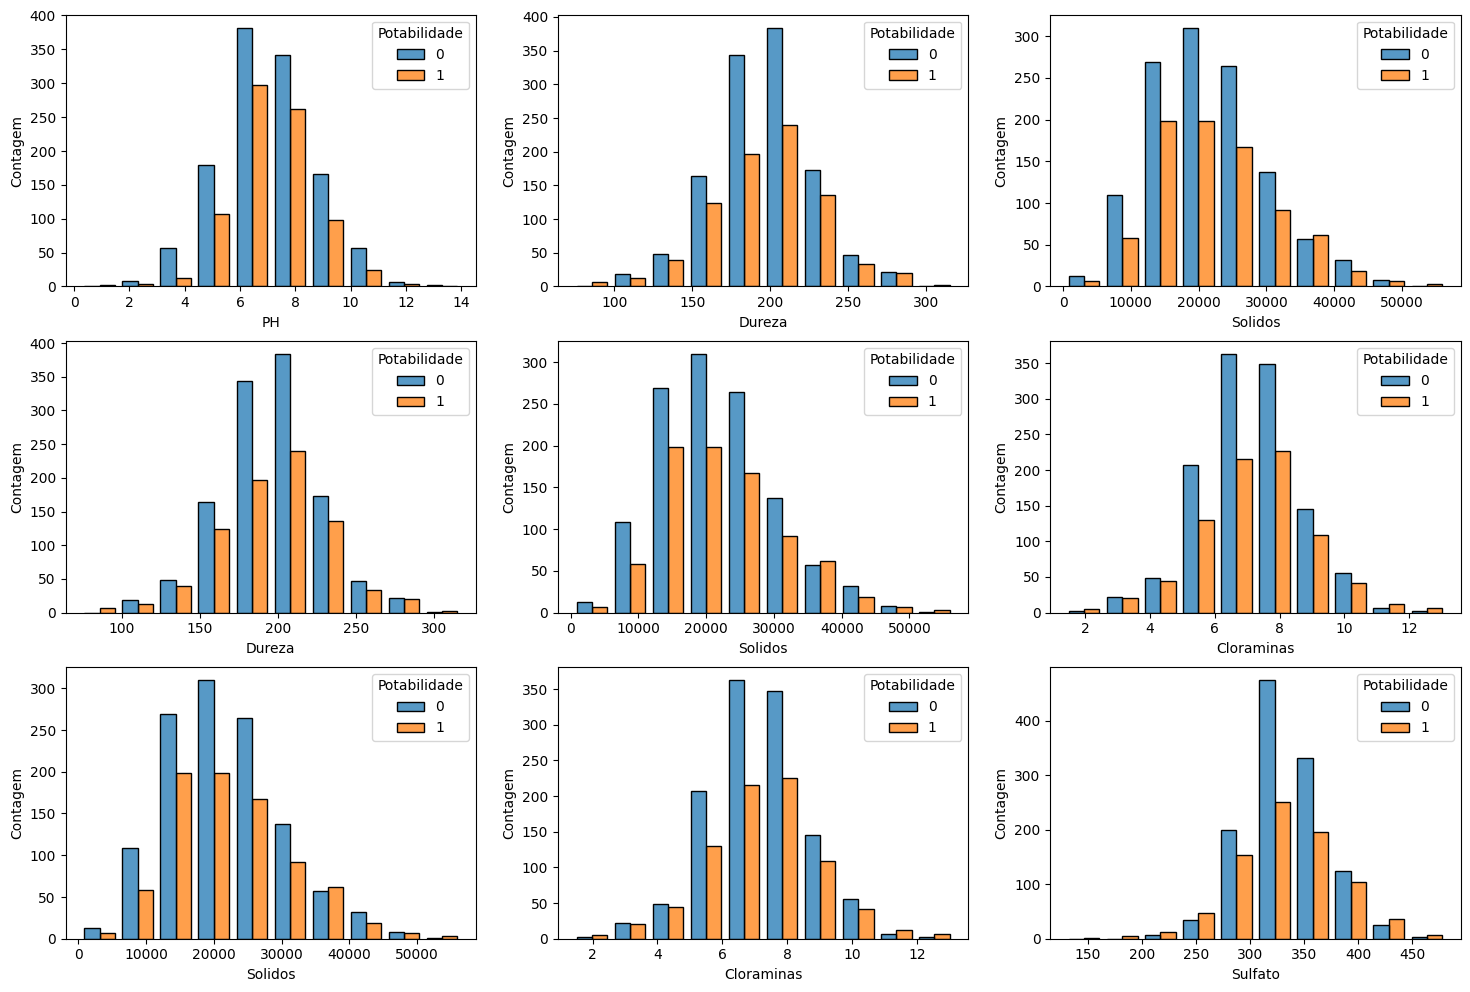

In [107]:
fig1, ax1 = plt.subplots(3, 3, figsize=(18, 12))
# fig1, ax1 = plt.subplots(1, 4, figsize=(18, 3))

for i in range(3):
    for j in range(3):

        sns.histplot(data=df, bins=10, x=colunas[i+j], hue=colunas[9], multiple='dodge', shrink=0.8, ax=ax1[i][j])
        ax1[i][j].set_xlabel(colunas[i+j])
        ax1[i][j].set_ylabel('Contagem') 
 
        



#### Utilizando PCA para reduzir a dimensionalidade dos dados

#### Primeiramente separamos o X ( features ) e o y ( target ) do dataset
#### Em seguida, normalizamos os dados utilizando o StandardScaler
#### Após isso, fazemos o split dos dados em treino e teste
#### Por fim, utilizamos o PCA para reduzir a dimensionalidade dos dados para 2 dimensões.

#### Aplicamos o PCA após o split dos dados para evitar o vazamento de dados do conjunto de teste para o conjunto de treino, conforme explicado pelo professor.

In [108]:
X = df.drop('Potabilidade', axis=1) # axis=1 para remover coluna
y = df['Potabilidade'] # Series

escalador = StandardScaler() # Instanciando o escalador
X = escalador.fit_transform(X) # Escalonando os dados

X = pd.DataFrame(X, columns=colunas[:-1]) # Transformando em DataFrame (fit_transform retorna um array numpy)

X.shape, y.shape # Verificando o shape dos dados
 
X_treino, X_teste, y_treino, y_teste = train_test_split(X, y, test_size=0.2, random_state=42) # Separando os dados em treino e teste


pca = PCA(n_components=2) # Instanciando o PCA

X_treino_pca = pca.fit_transform(X_treino) # Aplicando o PCA nos dados de treino
X_teste_pca = pca.transform(X_teste)  # Aplicando o PCA nos dados de teste


X_treino_pca.shape, X_teste_pca.shape

X_treino_pca = pd.DataFrame(X_treino_pca, columns=['P1', 'P2']) # Transformando em DataFrame
X_teste_pca = pd.DataFrame(X_teste_pca, columns=['P1', 'P2']) # Transformando em DataFrame

 
    
    

### Gráficos dos dados após a aplicação do PCA

#### Considerações:
- Mesmo após a redução da dimensionalidade, os dados ainda estão bem misturados.
- Não é possível separar os dados de maneira satisfatória nem utilizando uma reta, nem definir outliers.

Text(0, 0.5, 'P2')

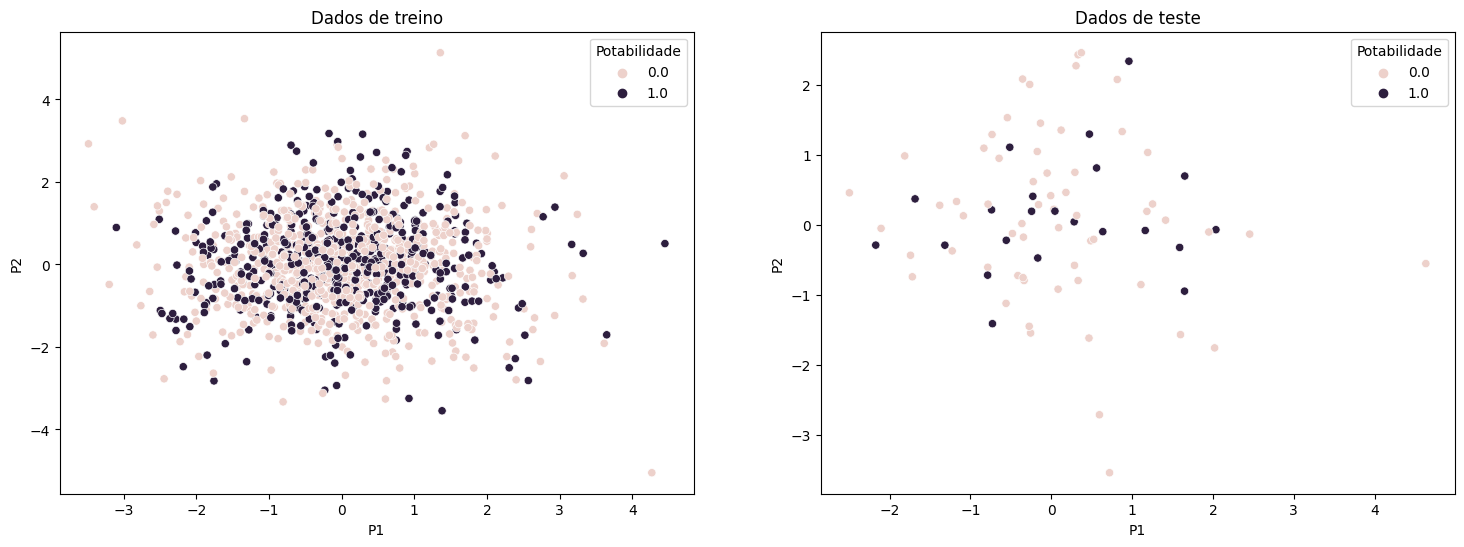

In [109]:
fig, ax = plt.subplots(1, 2, figsize=(18, 6))



sns.scatterplot(data=X_treino_pca, x='P1', y='P2', hue=y_treino, ax=ax[0])
ax[0].set_title('Dados de treino')
ax[0].set_xlabel('P1')
ax[0].set_ylabel('P2')

sns.scatterplot(data=X_teste_pca, x='P1', y='P2', hue=y_teste, ax=ax[1])
ax[1].set_title('Dados de teste')
ax[1].set_xlabel('P1')
ax[1].set_ylabel('P2')




### Classificação dos dados utilizando o KNN em validação cruzada de 2 niveis


#### Considerações:

- O KNN não foi capaz de classificar os dados de maneira satisfatória, obtendo uma acurácia de 57% no teste e 62% no treino.
- O desvio padrão é baixo, indicando que não está ocorrendo overfitting.


In [131]:
neighbors = np.arange(1, 100) # Array com os valores de k a serem testados
param_grid = {'n_neighbors': neighbors} # Dicionário com os parâmetros a serem testados

knn = KNeighborsClassifier() # Instanciando o KNN

skf_nivel_1 = StratifiedKFold(n_splits=5, shuffle=True, random_state=42) # Instanciando o KFold

grid1 = GridSearchCV(knn, param_grid, cv=skf_nivel_1, scoring='accuracy') # Instanciando o GridSearch

grid1.fit(X_treino_pca, y_treino) # Treinando o GridSearch


## fazendo validaçao cruzada de 2 niveis (5 e 10)

skf_nivel_2 = StratifiedKFold(n_splits=10, shuffle=True, random_state=42) # Instanciando o KFold

grid2 = GridSearchCV(knn, param_grid, cv=skf_nivel_2, scoring='accuracy') # Instanciando o GridSearch

grid2.fit(X_treino_pca, y_treino) # Treinando o GridSearch

print(f'Para nivel 1: \t Melhor K: {grid1.best_params_["n_neighbors"]} \t Acurácia no treino: {grid1.best_score_} \t Acurácia no teste: {accuracy_score(y_teste, grid1.predict(X_teste_pca))} Desvio padrão: {grid1.cv_results_["std_test_score"][grid1.best_index_]}')
print(f'Para nivel 2: \t Melhor K: {grid.best_params_["n_neighbors"]} \t Acurácia no treino: {grid.best_score_} \t Acurácia no teste: {accuracy_score(y_teste, grid.predict(X_teste_pca))} Desvio padrão: {grid.cv_results_["std_test_score"][grid.best_index_]}')





Para nivel 1: 	 Melhor K: 30 	 Acurácia no treino: 0.623136162225963 	 Acurácia no teste: 0.5732009925558312 Desvio padrão: 0.005546081536672994
Para nivel 2: 	 Melhor K: 24 	 Acurácia no treino: 0.626238354037267 	 Acurácia no teste: 0.56575682382134 Desvio padrão: 0.03423426418039437


## Conclusão
### Não foi possível classificar os dados de maneira satisfatória utilizando o KNN. 
### Isso pode ser explicado pelo fato de que os dados estão bem misturados, dificultando a separação e reconhecimento de padrões.
